<a href="https://colab.research.google.com/github/michaelywg/images/blob/master/part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 3: Train With Larger Dataset

First, let's load in the dataset and a pre-trained model to build off of.

In [2]:
# Load in the training and validation data
%%capture
import os 
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'
if not os.path.exists('/content/labels_ibug_300W_test_parsed.xml'):
    !wget https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/labels_ibug_300W_test_parsed.xml

### Dataloader
For this model, I wrote a custom dataloader to crop each facial image, resize it to 224x224, and get keypoint coordinates. I also applied the same data augmentation transformations as in part 2.

In [3]:
# Dataloader
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32')


In [4]:
# for i in range(len(bboxes)):
#   xunit, yunit = 0.1 * bboxes[i][0], 0.1 * bboxes[i][1]
#   bboxes[i][0] -= xunit
#   bboxes[i][1] -= yunit
#   bboxes[i][2] += 2 * xunit
#   bboxes[i][3] += 2 * yunit

In [5]:
# Actual Dataset for images, along with transformations for data augmentation
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import skimage
from skimage import io as skio, transform
from google.colab import files
from tqdm import tqdm
import warnings
# ignore warnings
warnings.filterwarnings("ignore")
torch.manual_seed(69)

class BigFaceDataset(Dataset):
    def __init__(self, image_fnames, landmarks, bboxes, transform=None):
        self.image_fnames = image_fnames[:]
        self.landmarks = landmarks[:]
        self.bboxes = bboxes[:]
        self.transform = transform

    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        result = dict()
        left, top, width, height = [int(pt) for pt in self.bboxes[idx]]
        left = int(max(0, left - 0.1 * width))
        top = int(max(0, top - 0.1 * height))
        width = int(width * 1.2)
        height = int(height * 1.2)
        landmarks = torch.Tensor(self.landmarks[idx]).detach().clone()
        landmarks[:, 0] = (landmarks[:, 0] - left) / width
        landmarks[:, 1] = (landmarks[:, 1] - top) / height
        image = skimage.color.rgb2gray(
            skio.imread(self.image_fnames[idx]))[top:top + height, left:left + width]
        image = transform.resize(image, (224, 224))
        if self.transform:
            image, landmarks = self.transform(image, landmarks)
        result['landmarks'] = landmarks
        result['image'] = torch.Tensor([image - 0.5])
        return result

# Define random transformations to augment the dataset and improve training robustness
class JitterColors:
    # Randomly jitter the brightness and saturation of an image
    def __call__(self, image, landmarks):
        return transforms.ColorJitter()(image), landmarks

class RandomRotation:
    def __init__(self, min_angle, max_angle):
        self.min_angle = min_angle
        self.max_angle = max_angle
        
    def __call__(self, image, landmarks):
        degrees = np.random.randint(self.min_angle, self.max_angle + 1)
        radians = -degrees * np.pi / 180.0
        image = transform.rotate(image, degrees)
        matrix = np.array([[np.cos(radians), -np.sin(radians)], [np.sin(radians), np.cos(radians)]])
        landmarks = torch.Tensor((np.matmul(matrix, landmarks.numpy().T - 0.5)).T) + 0.5
        return image, landmarks

class RandomShift:
    def __init__(self, min_px, max_px):
        self.min_px = min_px
        self.max_px = max_px
    
    def __call__(self, image, landmarks):
        vertical = np.random.randint(self.min_px, self.max_px + 1)
        horizontal = np.random.randint(self.min_px, self.max_px + 1)
        image = np.roll(image, vertical, axis=0)
        image = np.roll(image, horizontal, axis=1)
        landmarks[:, 0] += horizontal/224.0
        landmarks[:, 1] += vertical/224.0
        return image, landmarks

class RandomHorizontalFlip:
    def __call__(self, image, landmarks):
        if np.random.randint(0, 2) == 1:
            image = image[:, ::-1]
            landmarks = landmarks.detach().clone()
            landmarks[:, 0] = 1 - landmarks[:, 0]
        return image, landmarks
    
# Callable class combining the above transformations
class AugmentData:
    def __call__(self, image, landmarks):
        for fn in [
            JitterColors(),
            RandomRotation(-15, 15),
            RandomShift(-10, 10),
            RandomHorizontalFlip()
            ]:
            image, landmarks = fn(image, landmarks)
        return image, landmarks

In [6]:
# Shuffle the dataset to avoid bias in choosing training and validation sets
np.random.seed(69)
np.random.shuffle(img_filenames)
np.random.seed(69)
np.random.shuffle(landmarks)
np.random.seed(69)
np.random.shuffle(bboxes)
TRAIN_SIZE = 6112
big_train_dataset = BigFaceDataset(img_filenames[:TRAIN_SIZE], landmarks[:TRAIN_SIZE], bboxes[:TRAIN_SIZE], transform=AugmentData())
big_valid_dataset = BigFaceDataset(img_filenames[TRAIN_SIZE:], landmarks[TRAIN_SIZE:], bboxes[TRAIN_SIZE:], transform=AugmentData())
big_total_dataset = BigFaceDataset(img_filenames, landmarks, bboxes, transform=AugmentData())

Example images from dataloader:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

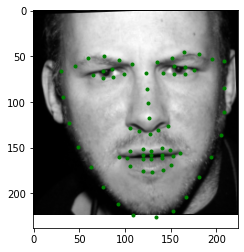

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

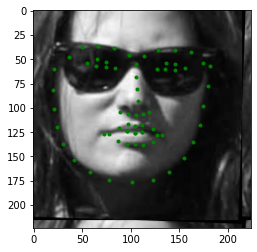

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

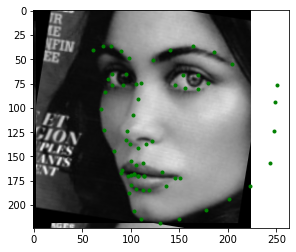

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

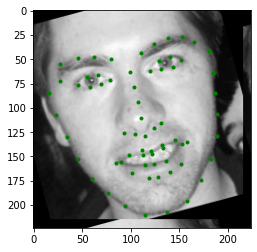

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

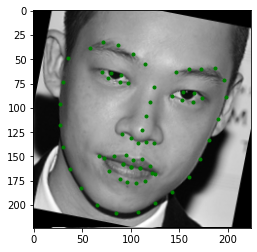

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

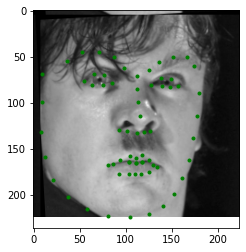

In [7]:
# Sample a few images and display them along with the ground-truth keypoints.
print('Example images from dataloader:')
for i in [12, 64, 69]:
  entry = big_train_dataset[i]
  plt.imshow(entry['image'].squeeze(0), cmap='gray')
  for x, y in entry['landmarks']:
    x, y = 224 * x, 224 * y
    plt.plot(x, y, 'go', ms=3)
  plt.savefig('big_dataloader_sample_{}.jpg'.format(i))
  files.download('big_dataloader_sample_{}.jpg'.format(i))
  plt.show()
for i in [12, 64, 69]:
  entry = big_valid_dataset[i]
  plt.imshow(entry['image'].squeeze(0), cmap='gray')
  for x, y in entry['landmarks']:
    x, y = 224 * x, 224 * y
    plt.plot(x, y, 'go', ms=3)
  plt.savefig('big_dataloader_sample_{}.jpg'.format(i))
  files.download('big_dataloader_sample_{}.jpg'.format(i))
  plt.show()

In [8]:
# import a pre-trained resnet18 model
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

# I will be using ResNet18 as a pre-trained model for this task.
# Below, I adjust ResNet18's input and output layers to match the input and output sizes for this task.
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2*68, bias=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Train resnet18 (rnet) on provided data for (epochs), updating weights with Adam
# and learning rate (rate).
# Returns a dictionary representing training loss and validation loss per epoch.
def TrainResNet(rnet, dataloader, epochs, rate=1e-3, validation_batches=20):
    lossfn = torch.nn.MSELoss()
    losses = {'training': [], 'validation': []}
    optimizer = torch.optim.Adam(rnet.parameters(), lr=rate)
    for e in range(epochs):
        print('Training epoch {}...'.format(e))
        train_loss = 0
        valid_loss = 0
        # Train with the training data
        for i, batch in tqdm(enumerate(dataloader)):
          if (i < validation_batches): 
            # Cross-validate on (validation_batches) random batches per epoch
            # Calculate the validation loss but DO NOT train/backprop with validation data.
            data, target = batch['image'].to(device), batch['landmarks'].to(device)
            output = rnet(data).view(data.shape[0], 68, 2)
            loss = lossfn(output, target)
            valid_loss += loss.item() * data.shape[0]
            del data
            del target
            torch.cuda.empty_cache()
          else:
            data, target = batch['image'].to(device), batch['landmarks'].to(device)
            optimizer.zero_grad()
            output = rnet(data).view(data.shape[0], 68, 2)
            loss = lossfn(output, target)
            train_loss += loss.item() * data.shape[0]
            loss.backward()
            optimizer.step()
            del data
            del target
            torch.cuda.empty_cache()
        final_loss = 0
        batch_size = 0
        for i, batch in enumerate(dataloader):
          batch_size = batch['image'].shape[0]
          break
        for i, batch in tqdm(enumerate(dataloader)):
          # Calculate final validation loss after training
          data, target = batch['image'].to(device), batch['landmarks'].to(device)
          output = rnet(data).view(data.shape[0], 68, 2)
          loss = lossfn(output, target)
          final_loss += loss.item() * data.shape[0]
          del data
          del target
          torch.cuda.empty_cache()
        train_loss /= (len(dataloader.dataset) - (validation_batches * batch_size))
        valid_loss /= (validation_batches * batch_size)
        losses['training'].append(train_loss)
        losses['validation'].append(valid_loss)
        print('Training loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(valid_loss))
        
    print('Done!')
    return losses

In [ ]:
# If to_train=False, load saved weights from npy. Else train the model.
to_train = True
big_dataloader = rnet_loss = None
trial = 3

if to_train:
  # Train the model
  big_dataloader = DataLoader(big_total_dataset, batch_size=4, shuffle=True)
  rnet_loss = TrainResNet(resnet18, big_dataloader, epochs=15, validation_batches=80)
  torch.save(resnet18.state_dict(), 'resnet_trained_weights_{}.npy'.format(trial))
  files.download('resnet_trained_weights_{}.npy'.format(trial))
  # Plot the training and validation loss over epochs
  plt.figure(figsize=(8, 8))
  plt.title('MSE Loss for training and validation vs epochs, iBug Faces')
  plt.xlabel('Epoch #')
  plt.ylabel('MSE Loss')
  plt.plot(np.arange(10), np.array(rnet_loss['training']), label='Training loss')
  plt.plot(np.arange(10), np.array(rnet_loss['validation']), label='Validation loss')
  plt.legend(loc="upper right")
  plt.savefig('ibug_accuracy_plot_{}.jpg'.format(trial), dpi=150, bbox_inches='tight')
  plt.show()
  files.download('ibug_accuracy_plot_{}.jpg'.format(trial))
else:
  # Load the model and loss graph and display them
  resnet18.load_state_dict(torch.load('resnet_trained_weights_{}.npy'.format(trial)))
  resnet18.eval()
  rnet_loss = plt.imread('ibug_accuracy_plot_{}.jpg'.format(trial))
  plt.figure(figsize=(10, 10))
  plt.imshow(rnet_loss)
  plt.show()


0it [00:00, ?it/s]

Training epoch 0...


392it [02:45,  2.16it/s]

In [ ]:
# Generate final predictions for testing dataset and generate Kaggle submission
# Load in the test images and bboxes
test_root = ET.parse('/content/labels_ibug_300W_test_parsed.xml').getroot()
test_fnames = []
test_bboxes = []
for entry in test_root[2]:
  test_fnames.append('/content/ibug_300W_large_face_landmark_dataset/' + entry.attrib['file'])
  test_bboxes.append([int(entry[0].attrib[key]) for key in ['left', 'top', 'width', 'height']])
test_fnames = np.array(test_fnames)
test_bboxes = np.array(test_bboxes)

In [ ]:
# Create a Dataset for test entries
big_test_dataset = BigFaceDataset(test_fnames, np.zeros((test_fnames.shape[0], 68, 2)), test_bboxes)

In [ ]:
# Generate test predictions
test_predictions = []
for batch in tqdm(DataLoader(big_test_dataset, batch_size=32, shuffle=False)):
  keypts = resnet18.forward(batch['image'].to(device))
  for kp in keypts:
    test_predictions.append(kp.cpu().detach().view(68, 2).numpy())
  del keypts
  torch.cuda.empty_cache()

In [ ]:
# Save predictions as csv file
import csv
with open('kaggle_predicts.csv', 'w') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['Id', 'Predicted'])
  id = 0
  for i in range(len(test_predictions)):
    left, top, width, height = [int(pt) for pt in test_bboxes[i]]
    preds = test_predictions[i] + 0
    preds[:, 0] = preds[:, 0] * width + left
    preds[:, 1] = preds[:, 1] * height + top
    preds = preds.astype(int)
    for kp in preds.flatten():
      writer.writerow([str(id), kp])
      id += 1
files.download('kaggle_predicts.csv')

In [ ]:
for idx in range(10, 50):
  plt.imshow(big_test_dataset[idx]['image'][0], cmap='gray')
  for x, y in test_predictions[idx]:
    x, y = 224 * x, 224 * y
    plt.plot(x, y, 'ro', ms=3)
  plt.show()
# for i in range

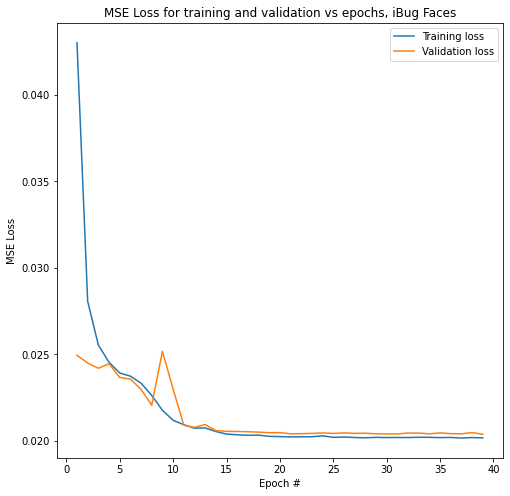

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(8, 8))
plt.title('MSE Loss for training and validation vs epochs, iBug Faces')
plt.xlabel('Epoch #')
plt.ylabel('MSE Loss')
plt.plot(np.arange(1, 40), np.array(rnet_loss['training'][1:]), label='Training loss')
plt.plot(np.arange(1, 40), np.array(rnet_loss['validation'][1:]), label='Validation loss')
plt.legend(loc="upper right")
plt.savefig('ibug_accuracy_plot_{}.jpg'.format(trial), dpi=150, bbox_inches='tight')
plt.show()
files.download('ibug_accuracy_plot_{}.jpg'.format(trial))

In [17]:
  files.download('resnet_trained_weights_1.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>